# AutoML: Train "the best" Image Classification Multi-Label model for a 'Fridge items' dataset.

**Requirements** - In order to benefit from this tutorial, you will need:
- A basic understanding of Machine Learning
- An Azure account with an active subscription. [Create an account for free](https://azure.microsoft.com/free/?WT.mc_id=A261C142F)
- An Azure ML workspace. [Check this notebook for creating a workspace](../../../resources/workspace/workspace.ipynb) 
- A Compute Cluster. [Check this notebook to create a compute cluster](../../../resources/compute/compute.ipynb)
- A python environment
- Installed Azure Machine Learning Python SDK v2 - [install instructions](../../../README.md) - check the getting started section

**Learning Objectives** - By the end of this tutorial, you should be able to:
- Connect to your AML workspace from the Python SDK
- Create an `AutoML Image Classification Multilabel Training Job` with the 'image_classification_multilabel()' factory-function.
- Train the model using AmlCompute by submitting/running the AutoML training job
- Obtaing the model and score predictions with it

**Motivations** - This notebook explains how to setup and run an AutoML image classification-multilabel job. This is one of the nine ML-tasks supported by AutoML. Other ML-tasks are 'forecasting', 'classification', 'image object detection', 'nlp text classification', etc.

In this notebook, we go over how you can use AutoML for training an Image Classification Multi-Label model. We will use a small dataset to train the model, demonstrate how you can tune hyperparameters of the model to optimize model performance and deploy the model to use in inference scenarios. 

# 1. Connect to Azure Machine Learning Workspace

The [workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-workspace) is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning. In this section we will connect to the workspace in which the job will be run.

## 1.1. Import the required libraries

In [1]:
# Import required libraries
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient

from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml import Input
from azure.ai.ml.automl import ImageClassificationSearchSpace
from azure.ai.ml.sweep import (
    Choice,
    Uniform,
    BanditPolicy,
)

from azure.ai.ml import automl

## 1.2. Configure workspace details and get a handle to the workspace

To connect to a workspace, we need identifier parameters - a subscription, resource group and workspace name. We will use these details in the `MLClient` from `azure.ai.ml` to get a handle to the required Azure Machine Learning workspace. We use the default [default azure authentication](https://docs.microsoft.com/en-us/python/api/azure-identity/azure.identity.defaultazurecredential?view=azure-python) for this tutorial. Check the [configuration notebook](../../configuration.ipynb) for more details on how to configure credentials and connect to a workspace.

In [2]:
credential = DefaultAzureCredential()
ml_client = None
try:
    ml_client = MLClient.from_config(credential)
except Exception as ex:
    print(ex)
    # Enter details of your AML workspace
    subscription_id = "<SUBSCRIPTION_ID>"
    resource_group = "<RESOURCE_GROUP>"
    workspace = "<AML_WORKSPACE_NAME>"
    subscription_id= "dbd697c3-ef40-488f-83e6-5ad4dfb78f9b"
    resource_group= "madhumaddi-rg"
    workspace= "madhumaddi-hd-onboard"
    ml_client = MLClient(credential, subscription_id, resource_group, workspace)

We could not find config.json in: . or in its parent directories. 


# 2. MLTable with input Training Data

In order to generate models for computer vision tasks with automated machine learning, you need to bring labeled image data as input for model training in the form of an MLTable. You can create an MLTable from labeled training data in JSONL format. If your labeled training data is in a different format (like, pascal VOC or COCO), you can use a conversion script to first convert it to JSONL, and then create an MLTable. Alternatively, you can use Azure Machine Learning's [data labeling tool](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-create-image-labeling-projects) to manually label images, and export the labeled data to use for training your AutoML model.

In this notebook, we use a toy dataset called Fridge Objects, which consists of 128 images of 4 labels of beverage container {can, carton, milk bottle, water bottle} photos taken on different backgrounds. It also includes a labels file in .csv format. This is one of the most common data formats for Image Classification Multi-Label: one csv file that contains the mapping of labels to a folder of images.

All images in this notebook are hosted in [this repository](https://github.com/microsoft/computervision-recipes) and are made available under the [MIT license](https://github.com/microsoft/computervision-recipes/blob/master/LICENSE).

**NOTE:** In this PRIVATE PREVIEW we're defining the MLTable in a separate folder and .YAML file.
In later versions, you'll be able to do it all in Python APIs.

## 2.1. Download the Data
We first download and unzip the data locally.

In [3]:
import os
import urllib
from zipfile import ZipFile

# download data
download_url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/image_classification/multilabelFridgeObjects.zip"
data_file = "./data/multilabelFridgeObjects.zip"
urllib.request.urlretrieve(download_url, filename=data_file)

# extract files
with ZipFile(data_file, "r") as zip:
    print("extracting files...")
    zip.extractall(path="./data")
    print("done")
# delete zip file
os.remove(data_file)

extracting files...
done


This is a sample image from this dataset:

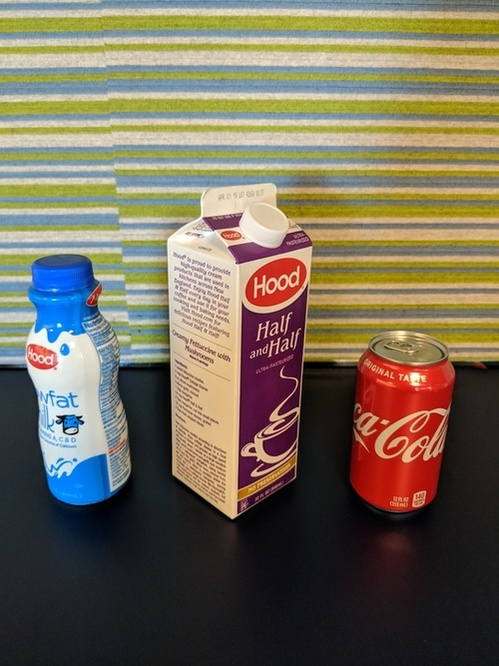

In [4]:
from IPython.display import Image

sample_image = "./data/multilabelFridgeObjects/images/56.jpg"
Image(filename=sample_image)

## 2.2. Upload the images to Datastore through an AML Data asset (URI Folder)

In order to use the data for training in Azure ML, we upload it to our default Azure Blob Storage of our  Azure ML Workspace.

[Check this notebook for AML data asset example](../../../assets/data/data.ipynb)

In [5]:
# Uploading image files by creating a 'data asset URI FOLDER':

from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

my_data = Data(
    path="./data/multilabelFridgeObjects",
    type=AssetTypes.URI_FOLDER,
    description="Fridge-items images multilabel",
    name="fridge-items-images-multilabel",
)

uri_folder_data_asset = ml_client.data.create_or_update(my_data)

print(uri_folder_data_asset)
print("")
print("Path to folder in Blob Storage:")
print(uri_folder_data_asset.path)

Uploading multilabelFridgeObjects (20.42 MBs): 100%|###############################################################| 20423623/20423623 [00:20<00:00, 996309.41it/s]




Data({'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_folder', 'is_anonymous': False, 'auto_increment_version': False, 'name': 'fridge-items-images-multilabel', 'description': 'Fridge-items images multilabel', 'tags': {}, 'properties': {}, 'id': '/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourceGroups/madhumaddi-rg/providers/Microsoft.MachineLearningServices/workspaces/madhumaddi-hd-onboard/data/fridge-items-images-multilabel/versions/1', 'base_path': './', 'creation_context': <azure.ai.ml._restclient.v2022_05_01.models._models_py3.SystemData object at 0x000001D0D1DEA088>, 'serialize': <msrest.serialization.Serializer object at 0x000001D0D1C05548>, 'version': '1', 'latest_version': None, 'path': 'azureml://subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourcegroups/madhumaddi-rg/workspaces/madhumaddi-hd-onboard/datastores/workspaceblobstore/paths/LocalUpload/75da6dddd4a47a30707c8c4fc737f5b9/multilabelFridgeObjects/'})

Path t

## 2.3. Convert the downloaded data to JSONL

In this example, the fridge object dataset is annotated in the CSV file, where each image corresponds to a line. It defines a mapping of the filename to the labels. Since this is a multi-label classification problem, each image can be associated to multiple labels. In order to use this data to create an AzureML MLTable, we first need to convert it to the required JSONL format. Please refer to the [documentation on how to prepare datasets](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-prepare-datasets-for-automl-images).


The following script is creating two .jsonl files (one for training and one for validation) in the corresponding MLTable folder. The train / validation ratio corresponds to 20% of the data going into the validation file.

In [6]:
import json
import os

src_images = "./data/multilabelFridgeObjects/"

# We'll copy each JSONL file within its related MLTable folder
training_mltable_path = "./data/training-mltable-folder/"
validation_mltable_path = "./data/validation-mltable-folder/"

train_validation_ratio = 5

# Path to the training and validation files
train_annotations_file = os.path.join(training_mltable_path, "train_annotations.jsonl")
validation_annotations_file = os.path.join(
    validation_mltable_path, "validation_annotations.jsonl"
)

# Baseline of json line dictionary
json_line_sample = {
    "image_url": uri_folder_data_asset.path,
    "label": [],
}

# Path to the labels file.
labelFile = os.path.join(src_images, "labels.csv")

# Read each annotation and convert it to jsonl line
with open(train_annotations_file, "w") as train_f:
    with open(validation_annotations_file, "w") as validation_f:
        with open(labelFile, "r") as labels:
            for i, line in enumerate(labels):
                # Skipping the title line and any empty lines.
                if i == 0 or len(line.strip()) == 0:
                    continue
                line_split = line.strip().split(",")
                if len(line_split) != 2:
                    print("Skipping the invalid line: {}".format(line))
                    continue
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"images/{line_split[0]}"
                json_line["label"] = line_split[1].strip().split(" ")

                if i % train_validation_ratio == 0:
                    # validation annotation
                    validation_f.write(json.dumps(json_line) + "\n")
                else:
                    # train annotation
                    train_f.write(json.dumps(json_line) + "\n")

## 2.4. Create MLTable data input

Create MLTable data input using the jsonl files created above.

In [7]:
# Training MLTable defined locally, with local data to be uploaded
my_training_data_input = Input(type=AssetTypes.MLTABLE, path=training_mltable_path)

# Validation MLTable defined locally, with local data to be uploaded
my_validation_data_input = Input(type=AssetTypes.MLTABLE, path=validation_mltable_path)

# WITH REMOTE PATH: If available already in the cloud/workspace-blob-store
# my_training_data_input = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/train")
# my_validation_data_input = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/valid")

To create data input from TabularDataset created using V1 sdk, specify the `type` as `AssetTypes.MLTABLE`, `mode` as `InputOutputModes.DIRECT` and `path` in the following format `azureml:<tabulardataset_name>:<version>`.

In [8]:
"""
# Training MLTable with v1 TabularDataset
my_training_data_input = Input(
    type=AssetTypes.MLTABLE, path="azureml:multilabelFridgeObjectsTrainingDataset:1",
    mode=InputOutputModes.DIRECT
)

# Validation MLTable with v1 TabularDataset
my_validation_data_input = Input(
    type=AssetTypes.MLTABLE, path="azureml:multilabelFridgeObjectsValidationDataset:1",
    mode=InputOutputModes.DIRECT
)
"""

'\n# Training MLTable with v1 TabularDataset\nmy_training_data_input = Input(\n    type=AssetTypes.MLTABLE, path="azureml:multilabelFridgeObjectsTrainingDataset:1",\n    mode=InputOutputModes.DIRECT\n)\n\n# Validation MLTable with v1 TabularDataset\nmy_validation_data_input = Input(\n    type=AssetTypes.MLTABLE, path="azureml:multilabelFridgeObjectsValidationDataset:1",\n    mode=InputOutputModes.DIRECT\n)\n'

# 3. Compute target setup

You will need to provide a [Compute Target](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#computes) that will be used for your AutoML model training. AutoML models for image tasks require [GPU SKUs](https://docs.microsoft.com/en-us/azure/virtual-machines/sizes-gpu) such as the ones from the NC, NCv2, NCv3, ND, NDv2 and NCasT4 series. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [9]:
from azure.ai.ml.entities import AmlCompute
from azure.core.exceptions import ResourceNotFoundError

compute_name = "gpu-cluster"

try:
    _ = ml_client.compute.get(compute_name)
    print("Found existing compute target.")
except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=compute_name,
        type="amlcompute",
        size="Standard_NC6",
        idle_time_before_scale_down=120,
        min_instances=0,
        max_instances=4,
    )
    ml_client.begin_create_or_update(compute_config)

Found existing compute target.


# 4. Configure and run the AutoML for Images Classification-Multilabel training job

AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model.

When using AutoML for image tasks, you need to specify the model algorithms using the model_name parameter. You can either specify a single model or choose to sweep over multiple models. Please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=CLI-v2#configure-model-algorithms-and-hyperparameters) for the list of supported model algorithms.

## 4.1. Using default hyperparameter values for the specified algorithm
Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values for a given model to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This allows an iterative approach, as with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially, and  you need more iterations to find optimal configurations.

Following functions are used to configure the AutoML image job:

### image_classification_multilabel() function parameters:
The `image_classification_multilabel()` factory function allows user to configure the training job.

- `compute` - The compute on which the AutoML job will run. In this example we are using a compute called 'gpu-cluster' present in the workspace. You can replace it any other compute in the workspace.
- `experiment_name` - The name of the experiment. An experiment is like a folder with multiple runs in Azure ML Workspace that should be related to the same logical machine learning experiment.
- `name` - The name of the Job/Run. This is an optional property. If not specified, a random name will be generated.
- `primary_metric` - The metric that AutoML will optimize for model selection.
- `target_column_name` - The name of the column to target for predictions. It must always be specified. This parameter is applicable to 'training_data' and 'validation_data'.
- `training_data` - The data to be used for training. It should contain both training feature columns and a target column. Optionally, this data can be split for segregating a validation or test dataset. 
You can use a registered MLTable in the workspace using the format '<mltable_name>:<version>' OR you can use a local file or folder as a MLTable. For e.g Input(mltable='my_mltable:1') OR Input(mltable=MLTable(local_path="./data"))
The parameter 'training_data' must always be provided.

### set_limits() parameters:
This is an optional configuration method to configure limits parameters such as timeouts.     
    
- `timeout_minutes` - Maximum amount of time in minutes that the whole AutoML job can take before the job terminates. If not specified, the default job's total timeout is 6 days (8,640 minutes).

### set_image_model() function parameters:
This is an optional configuration method to configure fixed settings or parameters that don't change during the parameter space sweep. Some of the key parameters of this function are:

- `model_name` - The name of the ML algorithm that we want to use in training job. Please refer to this [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=CLI-v2#supported-model-algorithms) for supported model algorithm.
- `number_of_epochs` - The number of training epochs. It must be positive integer (default value is 15).
- `layers_to_freeze` - The number of layers to freeze in model for transfer learning. It must be a positive integer (default value is 0).
- `early_stopping` - It enable early stopping logic during training, It must be boolean value (default is True).   
- `optimizer` - Type of optimizer to use in training. It must be either sgd, adam, adamw (default is sgd).
- `distributed` - It enable distributed training if compute target contain multiple GPUs. It must be boolean value (default is True).

If you wish to use the default hyperparameter values for a given algorithm (say `vitb16r224`), you can specify the job for your AutoML Image runs as follows:

In [10]:
# general job parameters
exp_name = "dpv2-image-classif-multi-label-experiment"

In [11]:
image_classification_multilabel_job = automl.image_classification_multilabel(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
)

image_classification_multilabel_job.set_limits(timeout_minutes=60)

image_classification_multilabel_job.set_image_model(model_name="vitb16r224")

Class ImageClassificationMultilabelJob: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


### Submitting an AutoML job for Computer Vision tasks
Once you've configured your job, you can submit it as a job in the workspace in order to train a vision model using your training dataset.

In [12]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(image_classification_multilabel_job)

print(f"Created job: {returned_job}")

Uploading training-mltable-folder (0.03 MBs): 100%|#######################################################################| 31455/31455 [00:01<00:00, 24639.98it/s]


Uploading validation-mltable-folder (0.01 MBs): 100%|########################################################################| 7826/7826 [00:01<00:00, 5844.24it/s]




Created job: ImageClassificationMultilabelJob({'log_verbosity': <LogVerbosity.INFO: 'Info'>, 'task_type': <TaskType.IMAGE_CLASSIFICATION_MULTILABEL: 'ImageClassificationMultilabel'>, 'environment_id': None, 'environment_variables': None, 'outputs': {}, 'type': 'automl', 'status': 'NotStarted', 'log_files': None, 'name': 'zen_sugar_92n7111w1w', 'description': None, 'tags': {}, 'properties': {'mlflow.source.git.repoURL': 'https://github.com/Azure/azureml-examples.git', 'mlflow.source.git.branch': 'main', 'mlflow.source.git.commit': '5028a5e5013d25be01ab00e4340c24b1c604b391', 'azureml.git.dirty': 'True'}, 'id': '/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourceGroups/madhumaddi-rg/providers/Microsoft.MachineLearningServices/workspaces/madhumaddi-hd-onboard/jobs/zen_sugar_92n7111w1w', 'base_path': './', 'creation_context': <azure.ai.ml._restclient.v2022_02_01_preview.models._models_py3.SystemData object at 0x000001D0D1DCF6C8>, 'serialize': <msrest.serialization.Serializer object

In [13]:
ml_client.jobs.stream(returned_job.name)

RunId: zen_sugar_92n7111w1w
Web View: https://ml.azure.com/runs/zen_sugar_92n7111w1w?wsid=/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourcegroups/madhumaddi-rg/workspaces/madhumaddi-hd-onboard

Execution Summary
RunId: zen_sugar_92n7111w1w
Web View: https://ml.azure.com/runs/zen_sugar_92n7111w1w?wsid=/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourcegroups/madhumaddi-rg/workspaces/madhumaddi-hd-onboard



## 4.2. Hyperparameter sweeping for your AutoML models for computer vision tasks

When using AutoML for Images, you can perform a hyperparameter sweep over a defined parameter space to find the optimal model. In this example, we sweep over the hyperparameters for `vitb16r224` and `seresnext` models, choosing from a range of values for learning_rate, gradient_accumulation_step, validation_resize_size, etc., to generate a model with the optimal 'iou'. If hyperparameter values are not specified, then default values are used for the specified algorithm.

set_sweep function is used to configure the sweep settings:
### set_sweep() parameters:

- `max_trials` - Required parameter for maximum number of configurations to sweep. Must be an integer between 1 and 1000. When exploring just the default hyperparameters for a given model algorithm, set this parameter to 1.
- `max_concurrent_trials` - Maximum number of runs that can run concurrently. If not specified, all runs launch in parallel. If specified, must be an integer between 1 and 100.
    NOTE: The number of concurrent runs is gated on the resources available in the specified compute target. Ensure that the compute target has the available resources for the desired concurrency.
- `sampling_algorithm` - Sampling method to use for sweeping over the defined parameter space. Please refer to this [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=SDK-v2#sampling-methods-for-the-sweep) for list of supported sampling methods.
- `early_termination` - Early termination policy to end poorly performing runs. If no termination policy is specified, all configurations are run to completion. Please refer to this [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=SDK-v2#early-termination-policies) for supported early termination policies.

We use Random Sampling to pick samples from this parameter space and try a total of 10 iterations with these different samples, running 2 iterations at a time on our compute target. Please note that the more parameters the space has, the more iterations you need to find optimal models.

We leverage the Bandit early termination policy which will terminate poor performing configs (those that are not within 20% slack of the best performing config), thus significantly saving compute resources.

For more details on model and hyperparameter sweeping, please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters).

In [ ]:
# Create the AutoML job with the related factory-function.

image_classification_multilabel_job = automl.image_classification_multilabel(
    compute=compute_name,
    # name="dpv2-image-classif-multi-label-job-02",
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
    primary_metric="iou",
    tags={"my_custom_tag": "My custom value"},
)

image_classification_multilabel_job.set_limits(timeout_minutes=60)

image_classification_multilabel_job.extend_search_space(
    [
        ImageClassificationSearchSpace(
            model_name=Choice(["vitb16r224"]),
            learning_rate=Uniform(0.005, 0.05),
            number_of_epochs=Choice([15, 30]),
            gradient_accumulation_step=Choice([1, 2]),
        ),
        ImageClassificationSearchSpace(
            model_name=Choice(["seresnext"]),
            learning_rate=Uniform(0.005, 0.05),
            # model-specific, valid_resize_size should be larger or equal than valid_crop_size
            validation_resize_size=Choice([288, 320, 352]),
            validation_crop_size=Choice([224, 256]),  # model-specific
            training_crop_size=Choice([224, 256]),  # model-specific
        ),
    ]
)

image_classification_multilabel_job.set_sweep(
    max_trials=10,
    max_concurrent_trials=2,
    sampling_algorithm="Random",
    early_termination=BanditPolicy(
        evaluation_interval=2, slack_factor=0.2, delay_evaluation=6
    ),
)

In [ ]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    image_classification_multilabel_job
)  # submit the job to the backend

print(f"Created job: {returned_job}")

In [ ]:
ml_client.jobs.stream(returned_job.name)

When doing a hyperparameter sweep, it can be useful to visualize the different configurations that were tried using the HyperDrive UI. You can navigate to this UI by going to the 'Child jobs' tab in the UI of the main automl image job from above, which is the HyperDrive parent run. Then you can go into the 'Trials' tab of this HyperDrive parent run. Alternatively, here below you can see directly the HyperDrive parent run and navigate to its 'Trials' tab:

In [ ]:
hd_job = ml_client.jobs.get(returned_job.name + "_HD")
hd_job

# 5. Retrieve the Best Trial (Best Model's trial/run)
Use the MLFLowClient to access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Trial.

## Initialize MLFlow Client

The models and artifacts that are produced by AutoML can be accessed via the MLFlow interface.
Initialize the MLFlow client here, and set the backend as Azure ML, via. the MLFlow Client.

IMPORTANT, you need to have installed the latest MLFlow packages with:

    pip install azureml-mlflow

    pip install mlflow

In [14]:
import mlflow

# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = ml_client.workspaces.get(
    name=ml_client.workspace_name
).mlflow_tracking_uri

print(MLFLOW_TRACKING_URI)

Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.PipelineRun = azureml.pipeline.core.run:PipelineRun._from_dto with exception (azureml-core 0.1.0.0 (c:\users\madhumaddi\workspace\azuremlcli\src\azureml-core), Requirement.parse('azureml-core~=1.42.0')).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.ReusedStepRun = azureml.pipeline.core.run:StepRun._from_reused_dto with exception (azureml-core 0.1.0.0 (c:\users\madhumaddi\workspace\azuremlcli\src\azureml-core), Requirement.parse('azureml-core~=1.42.0')).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.StepRun = azureml.pipeline.core.run:StepRun._from_dto with exception (azureml-core 0.1.0.0 (c:\users\madhumaddi\workspace\azuremlcli\src\azureml-core), Requirement.parse('azureml-core~=1.42.0')).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.scriptrun = azureml.core.script_run:ScriptRun._from_run

azureml://eastus2.api.azureml.ms/mlflow/v1.0/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourceGroups/madhumaddi-rg/providers/Microsoft.MachineLearningServices/workspaces/madhumaddi-hd-onboard


In [15]:
# Set the MLFLOW TRACKING URI

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

print("\nCurrent tracking uri: {}".format(mlflow.get_tracking_uri()))


Current tracking uri: azureml://eastus2.api.azureml.ms/mlflow/v1.0/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourceGroups/madhumaddi-rg/providers/Microsoft.MachineLearningServices/workspaces/madhumaddi-hd-onboard


In [16]:
from mlflow.tracking.client import MlflowClient

# Initialize MLFlow client
mlflow_client = MlflowClient()

### Get the AutoML parent Job

In [17]:
job_name = returned_job.name

# Example if providing an specific Job name/ID
# job_name = "salmon_camel_5sdf05xvb3"

# Get the parent run
mlflow_parent_run = mlflow_client.get_run(job_name)

print("Parent Run: ")
print(mlflow_parent_run)

Parent Run: 
<Run: data=<RunData: metrics={'AUC_macro': 0.99802,
 'AUC_micro': 0.99956,
 'AUC_weighted': 0.9978,
 'accuracy': 0.88,
 'average_precision_score_macro': 0.99927,
 'average_precision_score_micro': 0.99977,
 'average_precision_score_weighted': 0.99919,
 'f1_score_macro': 0.97762,
 'f1_score_micro': 0.97744,
 'f1_score_weighted': 0.97809,
 'iou': 0.96667,
 'iou_macro': 0.95743,
 'iou_micro': 0.95588,
 'iou_train': 0.90615,
 'iou_weighted': 0.95828,
 'log_loss': 0.12347,
 'log_loss_train': 0.21324,
 'precision_score_macro': 0.95743,
 'precision_score_micro': 0.95588,
 'precision_score_weighted': 0.95828,
 'recall_score_macro': 1.0,
 'recall_score_micro': 1.0,
 'recall_score_weighted': 1.0}, params={}, tags={'automl_best_child_run_id': 'zen_sugar_92n7111w1w_HD_0',
 'fit_time': '<NaN>;',
 'iteration': '<0>;',
 'mlflow.rootRunId': 'zen_sugar_92n7111w1w',
 'mlflow.runName': 'zen_sugar_92n7111w1w',
 'mlflow.user': 'Madhu Maddi',
 'model_explain_run': 'best_run',
 'pipeline_id': '<U

In [18]:
# Print parent run tags. 'automl_best_child_run_id' tag should be there.
print(mlflow_parent_run.data.tags.keys())

dict_keys(['model_explain_run', 'pipeline_id', 'score', 'predicted_cost', 'fit_time', 'training_percent', 'iteration', 'run_preprocessor', 'run_algorithm', 'automl_best_child_run_id', 'mlflow.rootRunId', 'mlflow.runName', 'mlflow.user'])


### Get the AutoML best child run

In [19]:
# Get the best model's child run

best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print("Found best child run id: ", best_child_run_id)

best_run = mlflow_client.get_run(best_child_run_id)

print("Best child run: ")
print(best_run)

Found best child run id:  zen_sugar_92n7111w1w_HD_0
Best child run: 
<Run: data=<RunData: metrics={'AUC_macro': 0.99802,
 'AUC_micro': 0.99956,
 'AUC_weighted': 0.9978,
 'accuracy': 0.88,
 'average_precision_score_macro': 0.99927,
 'average_precision_score_micro': 0.99977,
 'average_precision_score_weighted': 0.99919,
 'f1_score_macro': 0.97762,
 'f1_score_micro': 0.97744,
 'f1_score_weighted': 0.97809,
 'iou': 0.96667,
 'iou_macro': 0.95743,
 'iou_micro': 0.95588,
 'iou_train': 0.90615,
 'iou_weighted': 0.95828,
 'log_loss': 0.12347,
 'log_loss_train': 0.21324,
 'precision_score_macro': 0.95743,
 'precision_score_micro': 0.95588,
 'precision_score_weighted': 0.95828,
 'recall_score_macro': 1.0,
 'recall_score_micro': 1.0,
 'recall_score_weighted': 1.0}, params={}, tags={'hyperparameters': '{"ignored_argument": 0}',
 'mlflow.parentRunId': 'zen_sugar_92n7111w1w_HD',
 'mlflow.rootRunId': 'zen_sugar_92n7111w1w',
 'mlflow.runName': 'sincere_carnival_ztd62ncl',
 'mlflow.source.name': 'hd_im

## Get best model run's metrics
Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [20]:
import pandas as pd

pd.DataFrame(best_run.data.metrics, index=[0]).T

,0
iou_train,0.90615
log_loss_train,0.21324
log_loss,0.12347
average_precision_score_weighted,0.99919
recall_score_micro,1.00000
AUC_micro,0.99956
f1_score_macro,0.97762
precision_score_weighted,0.95828
precision_score_macro,0.95743
average_precision_score_micro,0.99977


## Download the best model locally
Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [21]:
# Create local folder
import os
local_dir = "./artifact_downloads"
if not os.path.exists(local_dir):
    os.mkdir(local_dir)

In [22]:
# Download run's artifacts/outputs
local_path = mlflow_client.download_artifacts(
    best_run.info.run_id, "outputs", local_dir
)
print("Artifacts downloaded in: {}".format(local_path))
print("Artifacts: {}".format(os.listdir(local_path)))

Artifacts downloaded in: C:\Users\madhumaddi\workspace\azureml-examples\sdk\jobs\automl-standalone-jobs\automl-image-classification-multilabel-task-fridge-items\artifact_downloads\outputs
Artifacts: ['conda_env_v_1_0_0.yml', 'mlflow-model', 'model.pt', 'run_id.txt', 'scoring_file_v_1_0_0.py']


In [23]:
import os

# Show the contents of the MLFlow model folder
os.listdir("./artifact_downloads/outputs/mlflow-model")

['artifacts',
 'conda.yaml',
 'MLmodel',
 'python_env.yaml',
 'python_model.pkl',
 'requirements.txt']

# 6. Register best model and deploy

## 6.1 Create managed online endpoint

In [24]:
# import required libraries
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
    ProbeSettings
)

In [27]:
# Creating a unique endpoint name with current datetime to avoid conflicts
import datetime

online_endpoint_name = "ic-ml-fd-items-" + datetime.datetime.now().strftime(
    "%m%d%H%M%f"
)

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="this is a sample online endpoint for deploying model",
    auth_mode="key",
    tags={"foo": "bar"},
)

In [28]:
ml_client.begin_create_or_update(endpoint)

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://ic-ml-fd-items-07091901550407.eastus2.inference.ml.azure.com/score', 'swagger_uri': 'https://ic-ml-fd-items-07091901550407.eastus2.inference.ml.azure.com/swagger.json', 'name': 'ic-ml-fd-items-07091901550407', 'description': 'this is a sample online endpoint for deploying model', 'tags': {'foo': 'bar'}, 'properties': {'azureml.onlineendpointid': '/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourcegroups/madhumaddi-rg/providers/microsoft.machinelearningservices/workspaces/madhumaddi-hd-onboard/onlineendpoints/ic-ml-fd-items-07091901550407', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/providers/Microsoft.MachineLearningServices/locations/eastus2/mfeOperationsStatus/oe:b4078513-81e3-4cc3-a3a7-158e26c41865:356205b8-532d-4e64-ae1f-217c409f1af2?api-version=2022-02-01-preview'}, 'id': '/subscriptions/dbd69

## 6.2 Register best model and deploy

### Register model

In [29]:
model_name = "ic-ml-fridge-items-model"
model = Model(
    path=f"azureml://jobs/{best_run.info.run_id}/outputs/artifacts/outputs/mlflow-model/",
    name=model_name,
    description="my sample object detection model",
    type="mlflow_model"
)

# for downloaded file
# model = Model(path="artifact_downloads/outputs/model.pt", name=model_name)

registered_model = ml_client.models.create_or_update(model)

In [30]:
best_run.info

<RunInfo: artifact_uri='azureml://experiments/dpv2-image-classif-multi-label-experiment/runs/zen_sugar_92n7111w1w_HD_0/artifacts', end_time=1657353606803, experiment_id='13ae63cd-9db6-4559-b167-953d6765e87f', lifecycle_stage='active', run_id='zen_sugar_92n7111w1w_HD_0', run_uuid='zen_sugar_92n7111w1w_HD_0', start_time=1657353201759, status='FINISHED', user_id='42947b02-be6c-4708-a326-3fbb21783dc9'>

In [31]:
registered_model.id

'/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourceGroups/madhumaddi-rg/providers/Microsoft.MachineLearningServices/workspaces/madhumaddi-hd-onboard/models/ic-ml-fridge-items-model/versions/1'

### Deploy

In [32]:
deployment = ManagedOnlineDeployment(
    name="ic-ml-mlflow-deploy",
    endpoint_name=online_endpoint_name,
    model=registered_model.id,
    instance_type="Standard_DS3_V2",
    instance_count=1,
    liveness_probe=ProbeSettings(
        failure_threshold=30,
        success_threshold=1,
        timeout=2,
        period=10,
        initial_delay=2000,
    ),
    readiness_probe=ProbeSettings(
        failure_threshold=10,
        success_threshold=1,
        timeout=10,
        period=10,
        initial_delay=2000
    )
)

In [33]:
ml_client.online_deployments.begin_create_or_update(deployment)

Check: endpoint ic-ml-fd-items-07091901550407 exists
Creating/updating online deployment ic-ml-mlflow-deploy 

......................................................................................................................................................................................................................................................................................................................................................................................................................................

Done (39m 14s)


In [34]:
# od fridge items deployment to take 100% traffic
endpoint.traffic = {"ic-ml-mlflow-deploy": 100}
ml_client.begin_create_or_update(endpoint)

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://ic-ml-fd-items-07091901550407.eastus2.inference.ml.azure.com/score', 'swagger_uri': 'https://ic-ml-fd-items-07091901550407.eastus2.inference.ml.azure.com/swagger.json', 'name': 'ic-ml-fd-items-07091901550407', 'description': 'this is a sample online endpoint for deploying model', 'tags': {'foo': 'bar'}, 'properties': {'azureml.onlineendpointid': '/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourcegroups/madhumaddi-rg/providers/microsoft.machinelearningservices/workspaces/madhumaddi-hd-onboard/onlineendpoints/ic-ml-fd-items-07091901550407', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/providers/Microsoft.MachineLearningServices/locations/eastus2/mfeOperationsStatus/oe:b4078513-81e3-4cc3-a3a7-158e26c41865:11545e96-e4c6-4965-a13e-15a4b869ab2c?api-version=2022-02-01-preview'}, 'id': '/subscriptions/dbd69

### Get endpoint details

In [35]:
# Get the details for online endpoint
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

# existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)

{'ic-ml-mlflow-deploy': 100}
https://ic-ml-fd-items-07091901550407.eastus2.inference.ml.azure.com/score


In [38]:
# Create request json
import base64

sample_image = "./data/multilabelFridgeObjects/images/99.jpg"

def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()

request_json = {
    "input_data": {
    "columns": [
      "image"
    ],
    "data": [
      base64.encodebytes(read_image(sample_image)).decode('utf-8')
    ]
  }
}

In [39]:
import json

request_file_name = "sample_request_data.json"

with open(request_file_name, "w") as request_file:
  json.dump(request_json, request_file)

In [40]:
resp = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name=deployment.name,
    request_file=request_file_name,
)

## Visualize detections
Now that we have scored a test image, we can visualize the bounding boxes for this image.

can (0.992)


<Figure size 1296x864 with 0 Axes>

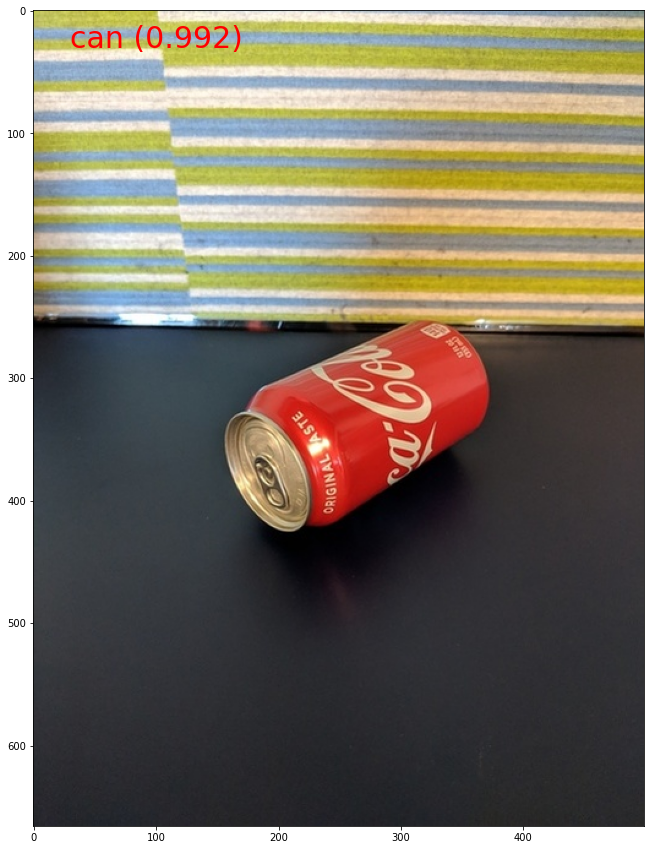

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18, 12)
plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(sample_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=(15, 15))
# Display the image
ax.imshow(img_np)

prediction = json.loads(resp)[0]
label_index = np.argmax(prediction["probs"])
label = prediction["labels"][label_index]
conf_score = prediction["probs"][label_index]

display_text = "{} ({})".format(label, round(conf_score, 3))
print(display_text)

color = "red"
plt.text(30, 30, display_text, color=color, fontsize=30)

plt.show()

# Next Steps
You can see further examples of other AutoML tasks such as Regression, Image-Object-Detection, NLP-Text-Classification, Time-Series-Forcasting, etc.